#Traditional Approaches

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from skimage.segmentation import slic
import networkx as nx

In [2]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Download and load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Define data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 32550219.05it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1817626.14it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 10334828.29it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 6663353.89it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



#Convolutional Neural Network (CNN)

In [3]:
# Define CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize CNN model
cnn_model = CNN()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


In [4]:
# Training the CNN model
def train_with_loss_curve_cnn(model, optimizer, criterion, train_loader, test_loader, num_epochs=5):
    model.train()
    train_losses_cnn = []
    test_losses_cnn = []
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        # Calculate average training loss
        epoch_train_loss = running_train_loss / len(train_loader)
        train_losses_cnn.append(epoch_train_loss)

        # Evaluate the model
        model.eval()
        running_test_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item()

        # Calculate average testing loss
        epoch_test_loss = running_test_loss / len(test_loader)
        test_losses_cnn.append(epoch_test_loss)

        print(f'Epoch {epoch + 1}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

    return train_losses_cnn, test_losses_cnn

train_losses_cnn, test_losses_cnn = train_with_loss_curve_cnn(cnn_model, optimizer, criterion, train_loader, test_loader)


Epoch 1, Train Loss: 0.2852, Test Loss: 0.0575
Epoch 2, Train Loss: 0.1029, Test Loss: 0.0391
Epoch 3, Train Loss: 0.0771, Test Loss: 0.0346
Epoch 4, Train Loss: 0.0622, Test Loss: 0.0330
Epoch 5, Train Loss: 0.0534, Test Loss: 0.0272


In [5]:
# Calculate accuracy
def calculate_accuracy_cnn(model, test_loader):
    model.eval()
    all_predicted_labels = []
    all_true_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_predicted_labels.extend(predicted.numpy())
            all_true_labels.extend(labels.numpy())
    accuracy = accuracy_score(all_true_labels, all_predicted_labels)
    return accuracy

accuracy_cnn = calculate_accuracy_cnn(cnn_model, test_loader)
print(f'Accuracy: {accuracy_cnn:.2f}')


Accuracy: 0.99


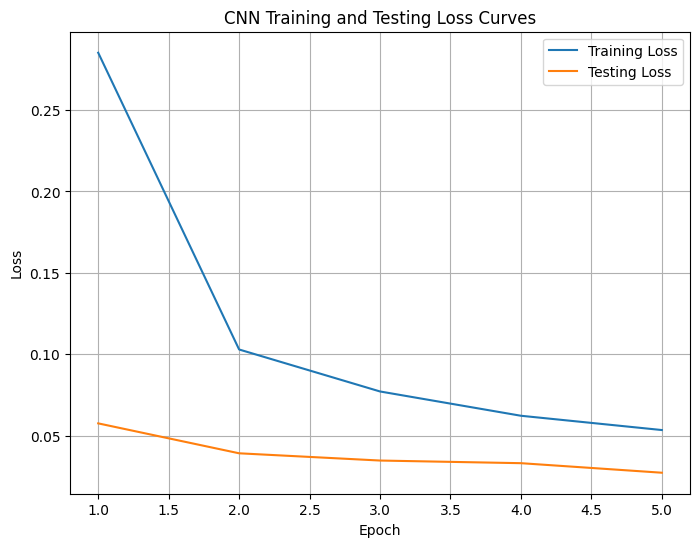

In [6]:
# Plot train/test loss curves
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses_cnn) + 1), train_losses_cnn, label='Training Loss')
plt.plot(range(1, len(test_losses_cnn) + 1), test_losses_cnn, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CNN Training and Testing Loss Curves')
plt.legend()
plt.grid(True)
plt.show()


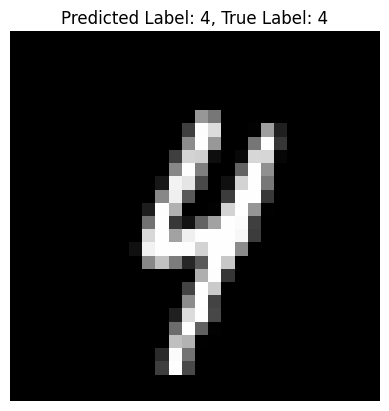

In [7]:
import random

# Select a random image from the testing dataset
random_index = random.randint(0, len(test_dataset) - 1)
random_image, random_label = test_dataset[random_index]

# Reshape the image
random_image = random_image.unsqueeze(0)

# Use the trained CNN model for prediction
with torch.no_grad():
    cnn_model.eval()
    output = cnn_model(random_image)
    _, predicted_label = torch.max(output, 1)

plt.imshow(random_image.squeeze(), cmap='gray')
plt.title(f'Predicted Label: {predicted_label.item()}, True Label: {random_label}')
plt.axis('off')
plt.show()


#Multilayer Perceptron (MLP)

In [8]:
# Define MLP architecture
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)  # Corrected input size
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Initialize MLP model
mlp_model = MLP()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


In [9]:
# Training the MLP model
def train_with_loss_curve_mlp(model, optimizer, criterion, train_loader, test_loader, num_epochs=5):
    model.train()
    train_losses_mlp = []
    test_losses_mlp = []
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            images = images.view(images.size(0), -1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        # Calculate average training loss
        epoch_train_loss = running_train_loss / len(train_loader)
        train_losses_mlp.append(epoch_train_loss)

        # Evaluate the model
        model.eval()
        running_test_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item()

        # Calculate average testing loss
        epoch_test_loss = running_test_loss / len(test_loader)
        test_losses_mlp.append(epoch_test_loss)

        print(f'Epoch {epoch + 1}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

    return train_losses_mlp, test_losses_mlp

train_losses_mlp, test_losses_mlp = train_with_loss_curve_mlp(mlp_model, optimizer, criterion, train_loader, test_loader)

Epoch 1, Train Loss: 0.6168, Test Loss: 0.2193
Epoch 2, Train Loss: 0.3308, Test Loss: 0.1578
Epoch 3, Train Loss: 0.2742, Test Loss: 0.1391
Epoch 4, Train Loss: 0.2412, Test Loss: 0.1248
Epoch 5, Train Loss: 0.2260, Test Loss: 0.1127


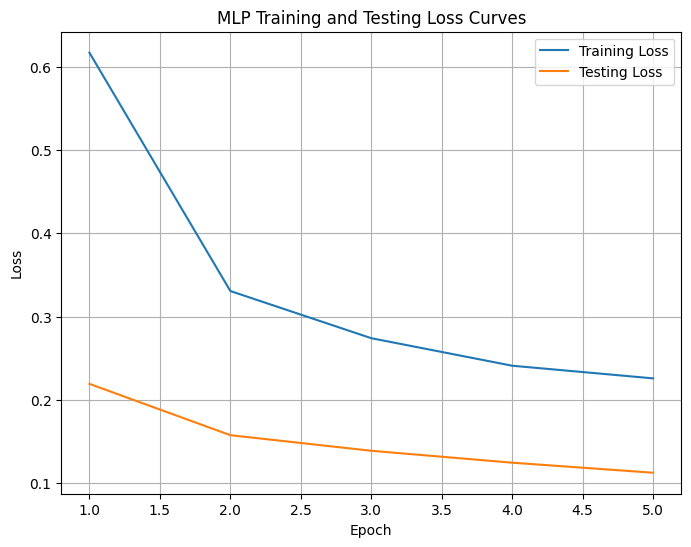

In [10]:
# Plot the train/test loss curves
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses_mlp) + 1), train_losses_mlp, label='Training Loss')
plt.plot(range(1, len(test_losses_mlp) + 1), test_losses_mlp, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MLP Training and Testing Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
def test_mlp(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            # Flatten the images
            images = images.view(images.size(0), -1)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

accuracy_mlp = test_mlp(mlp_model, test_loader)
print(f'Accuracy: {accuracy_mlp * 100:.2f}%')

Accuracy: 96.63%


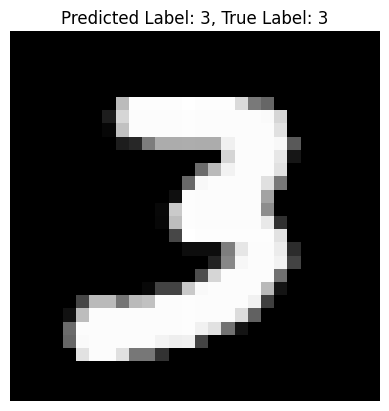

In [12]:
# Select a random image from the testing dataset
random_index = random.randint(0, len(test_dataset) - 1)
random_image, random_label = test_dataset[random_index]

# Reshape the image
reshaped_image = random_image.view(28, 28)

flattened_image = random_image.view(-1)

# Use the trained MLP model for prediction
with torch.no_grad():
    mlp_model.eval()
    output = mlp_model(flattened_image.unsqueeze(0))
    _, predicted_label = torch.max(output, 1)

plt.imshow(reshaped_image, cmap='gray')
plt.title(f'Predicted Label: {predicted_label.item()}, True Label: {random_label}')
plt.axis('off')
plt.show()


#Recurrent Neural Network (RNN)

In [13]:
# Define RNN/LSTM architecture
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.lstm = nn.LSTM(input_size=28, hidden_size=128, num_layers=1, batch_first=True)
        self.fc = nn.Linear(128, 10)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        x = self.fc(h_n[-1])
        return x

# Initialize RNN model
rnn_model = RNN()
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


In [14]:
# Training the RNN model
def train_with_loss_curve_rnn(model, optimizer, criterion, train_loader, test_loader, num_epochs=5):
    model.train()
    train_losses_rnn = []
    test_losses_rnn = []
    for epoch in range(num_epochs):
        running_train_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            # Reshape input images to 2D
            images = images.view(-1, 28, 28)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        # Calculate average training loss
        epoch_train_loss = running_train_loss / len(train_loader)
        train_losses_rnn.append(epoch_train_loss)

        # Evaluate the model
        model.eval()
        running_test_loss = 0.0
        total_correct = 0
        total_samples = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.view(-1, 28, 28)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_correct += (predicted == labels).sum().item()
                total_samples += labels.size(0)

        # Calculate average testing loss
        epoch_test_loss = running_test_loss / len(test_loader)
        test_losses_rnn.append(epoch_test_loss)

        # Calculate accuracy
        accuracy_rnn = total_correct / total_samples

        print(f'Epoch {epoch + 1}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}, Accuracy: {accuracy_rnn * 100:.2f}%')

    return train_losses_rnn, test_losses_rnn, accuracy_rnn

train_losses_rnn, test_losses_rnn, accuracy_rnn = train_with_loss_curve_rnn(rnn_model, optimizer, criterion, train_loader, test_loader)


Epoch 1, Train Loss: 0.4650, Test Loss: 0.1961, Accuracy: 94.10%
Epoch 2, Train Loss: 0.1481, Test Loss: 0.1130, Accuracy: 96.47%
Epoch 3, Train Loss: 0.0990, Test Loss: 0.1197, Accuracy: 96.45%
Epoch 4, Train Loss: 0.0781, Test Loss: 0.0775, Accuracy: 97.62%
Epoch 5, Train Loss: 0.0632, Test Loss: 0.0634, Accuracy: 98.24%


In [15]:
print(f'Final Accuracy: {accuracy_rnn * 100:.2f}%')

Final Accuracy: 98.24%


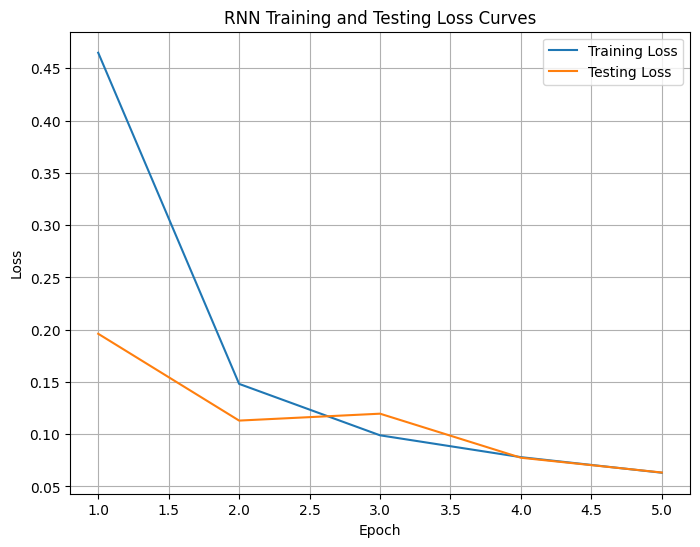

In [16]:
# Plot the train/test loss curves
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses_rnn) + 1), train_losses_rnn, label='Training Loss')
plt.plot(range(1, len(test_losses_rnn) + 1), test_losses_rnn, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('RNN Training and Testing Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

#Comparing the three traditional approachs (CNN, MLP, RNN)

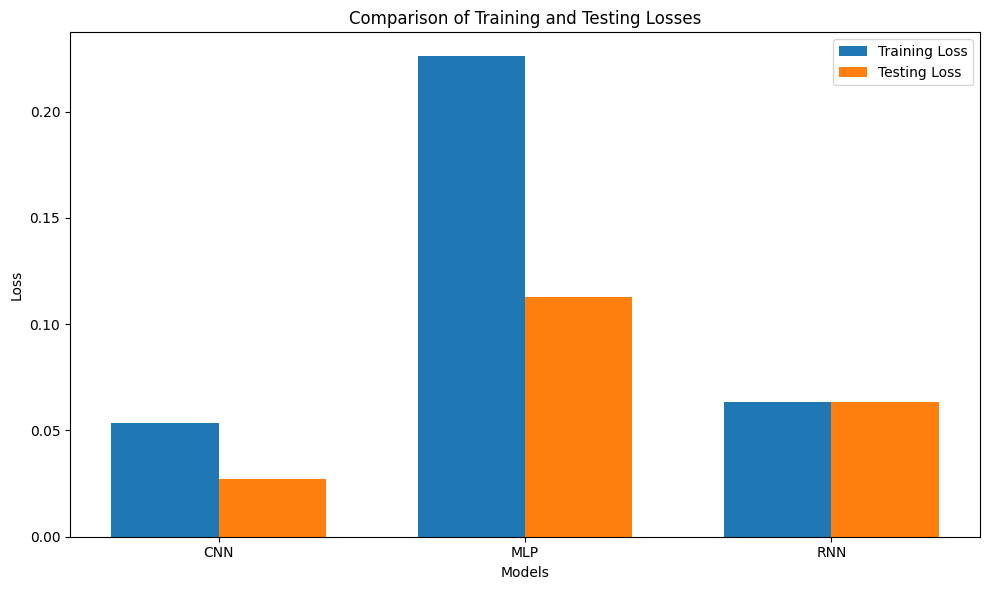

In [17]:
models = ['CNN', 'MLP', 'RNN']
train_losses = [train_losses_cnn[-1], train_losses_mlp[-1], train_losses_rnn[-1]]
test_losses = [test_losses_cnn[-1], test_losses_mlp[-1], test_losses_rnn[-1]]

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35

index = np.arange(len(models))

# Plot the training losses
train_bars = ax.bar(index, train_losses, bar_width, label='Training Loss')

# Plot the testing losses
test_bars = ax.bar(index + bar_width, test_losses, bar_width, label='Testing Loss')

# Add labels, title, and legend
ax.set_xlabel('Models')
ax.set_ylabel('Loss')
ax.set_title('Comparison of Training and Testing Losses')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(models)
ax.legend()

plt.tight_layout()
plt.show()


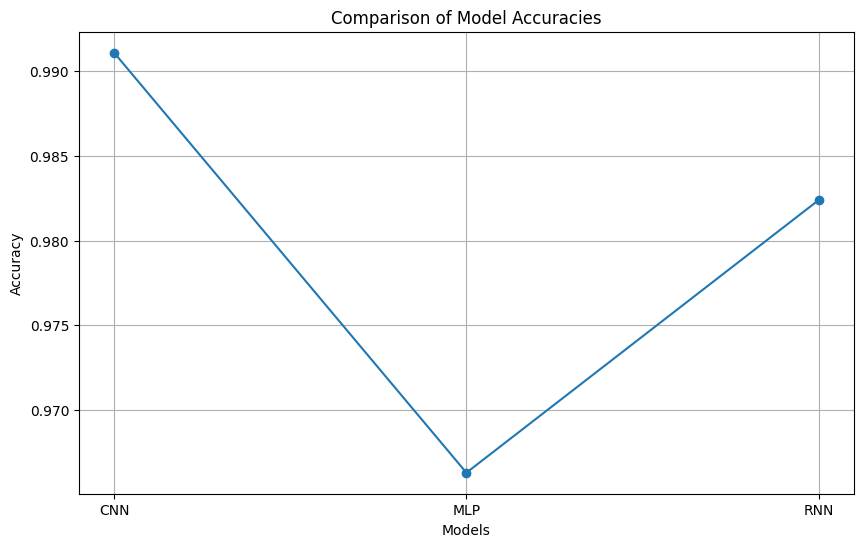

In [18]:
models = ['CNN', 'MLP', 'RNN']
accuracies = [accuracy_cnn, accuracy_mlp, accuracy_rnn]

# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(models, accuracies, marker='o')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')

plt.grid(True)
plt.show()
